In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch


from depth_anything_v2.dpt import DepthAnythingV2 as DepthAnythingV2

In [3]:

def show_3d(pred):
    # 三维展示像素值大小
    h,w = pred.shape
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, w, 1)
    y = np.arange(0, h, 1)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, pred, cmap='coolwarm')
    plt.show()

def align(pred,gt):
    return pred * (np.median(gt) / np.median(pred))

def show_metric(pred, gt):
    rmse = np.sqrt(np.mean((pred - gt) ** 2))
    mae = np.mean(np.abs(pred - gt))
    absrel = np.median(np.abs(pred - gt) / (gt+1e-6))
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"ABS REL: {absrel}")

In [10]:
model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }
load_from = "/Disk_2/ZanXin/Depth-Anything-V2/checkpoints/depth_anything_v2_vitl.pth"
depth_anything = DepthAnythingV2(**{**model_configs['vitl']})
depth_anything.load_state_dict(torch.load(load_from, map_location='cpu'))
depth_anything = depth_anything.to('cuda').eval()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4142135623730951].


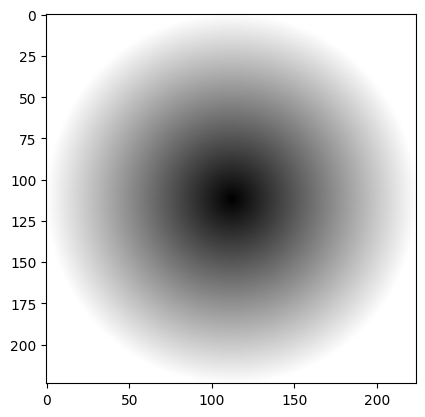

In [11]:
# 生成一张中间黑，向四周逐渐变暗的图，距离中心相同距离的像素值相同
def generate_heatmap():
    heatmap = np.zeros((224, 224))
    center = (112, 112)
    for i in range(224):
        for j in range(224):
            heatmap[i, j] = 1 - np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2) / 112
    return heatmap

# 给输入图片加高斯噪声
def add_gaussian_noise(image, mean=0, std=1):
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)

# 生成一张高斯噪声的三通道图片
def generate_noise_image(h,w):
    noise = np.random.normal(0, 1, (h, w, 3))
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))
    return (noise*255).astype(np.uint8)

def swap_img_part(img):
    pass

sample = generate_heatmap()
# [224,224] -> [224,224,3]
sample = np.stack([sample, sample, sample], axis=2)
sample = 1 - sample
plt.imshow(sample, cmap='gray')

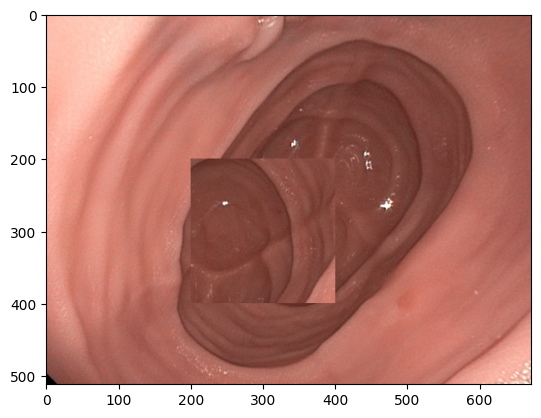

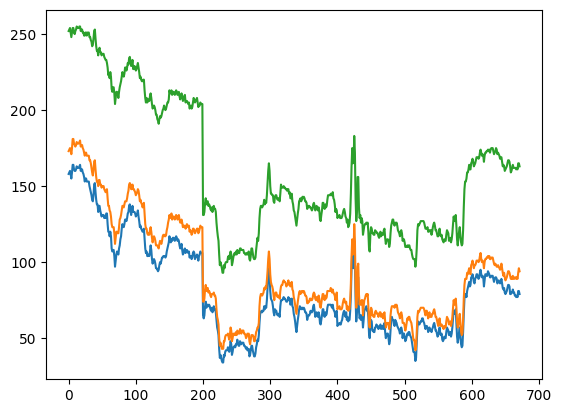

In [34]:



img_path = "/home/zanxin/jiahan/.dataset4SCDepth/scene_cecum_t4_b/00000.jpg"
gt = np.load("/home/zanxin/jiahan/.dataset4SCDepth/scene_cecum_t4_b/depth_gt/00000.npy")
# img_path = "/home/zanxin/jiahan/T1/C_T1_L1_1_resized/FrameBuffer_0382.png"
# img_path = "/home/zanxin/jiahan/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/FrameBuffer_0001.png"
# gt = np.load("/home/zanxin/jiahan/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/depth_gt/FrameBuffer_0001.npy")
# img = (sample * 255).astype(np.uint8)
# gt = 1/(np.power(sample,2) + 1)[...,0]

img = cv2.imread(img_path).astype(np.uint16)
h,w,_ = img.shape
# img = add_gaussian_noise(img, mean=0, std=10000)
# img = generate_noise_image(img.shape[0], img.shape[1])
# img = np.zeros_like(img)*255
# 三通道图大于255的变成255
# img = np.clip(img+100, 0, 255).astype(np.uint8)
# img[...,0] = 255

# 交换img的左上角和右下角
# 随机翻转图中某个范围内的像素
start = (200,200)
def flip_part(img, start, size):
    tmp = img[start[0]:start[0]+size, start[1]:start[1]+size].copy()
    tmp = np.flip(tmp, axis=0)
    img[start[0]:start[0]+size, start[1]:start[1]+size] = np.flip(tmp, axis=1)
    return img

def swap_const(img):
    h,w,_ = img.shape
    tmp = img[:int(h/2), :int(w/2)].copy()
    img[:int(h/2), :int(w/2)] = img[int(h/2):, int(w/2):]
    img[int(h/2):, int(w/2):] = tmp

img = flip_part(img, start, 200)
plt.imshow(img[...,::-1])

plt.figure()
plt.plot(img[200])

# output = model.infer_image(img)
output_dany = depth_anything.infer_image(img)


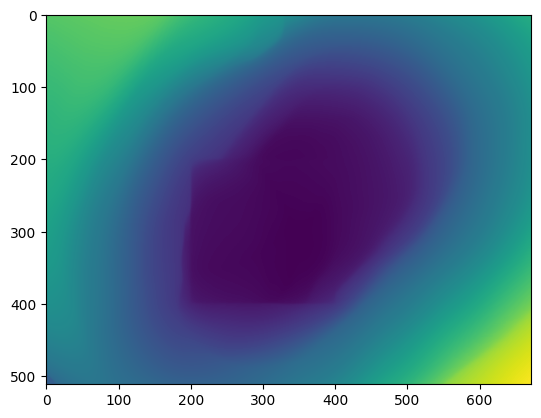

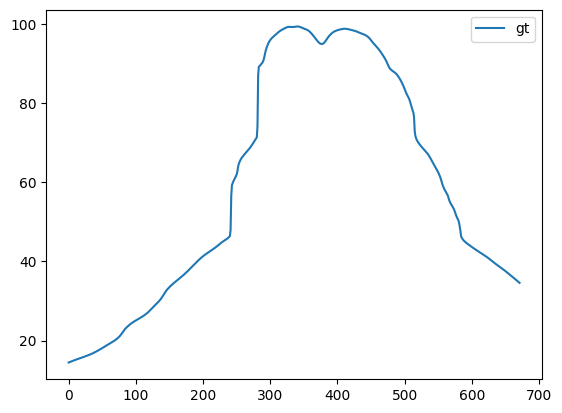

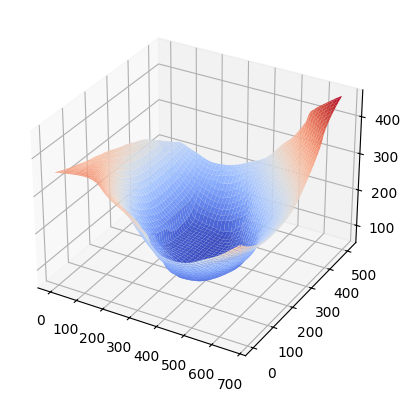

------
RMSE: 184.41495429950723
MAE: 152.50555393680398
ABS REL: 3.753320684457542


In [35]:
# pred = output.copy()
pred_dany = output_dany.copy()


# pred = align(pred,gt)
# pred_dany = align(pred_dany,gt)

# left is pred, right is pred_dany
plt.figure()
plt.imshow(pred_dany)


plt.figure()
plt.plot(gt[200,], label='gt')
plt.legend()

show_3d(pred_dany)

print("------")
show_metric(pred_dany,gt)

In [3]:
# run.py 的加载方式

DEVICE = "cuda"

model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }

from depth_anything_v2.dpt import DepthAnythingV2
depth_anything = DepthAnythingV2(**{**model_configs['vitl'], 'max_depth': 200})
# depth_anything.load_state_dict(torch.load("/Disk_2/ZanXin/Depth-Anything-V2/metric_depth/123.pth", map_location='cpu'), strict=True)
depth_anything.load_state_dict(torch.load("/Disk_2/ZanXin/Depth-Anything-V2/train_checkpoints/UCL/latest.pth", map_location='cpu')['model'], strict=True)
depth_anything = depth_anything.to(DEVICE).eval()